In [1]:
%matplotlib inline

# Imports

In [2]:
import glob
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi


###The following is used to create some sensible results folders according to the year/month
import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

# Custom plotting parameters

In [3]:
import matplotlib
###Default for jupyter display
matplotlib.rcParams['figure.dpi']= 150

matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.8'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['legend.fontsize'] = 10
# matplotlib.rcParams['text.usetex'] = True


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Load in the combined `.tsv` file and some notebook-wide variables


In [4]:
combined_df = pd.read_csv('../Data/562_associated_data/ecoli.combined.tsv', sep='\t', index_col=0)
combined_df.head()

,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,...,GC_upstream,locus_tag,secondary_structure,secondary_structure_internal,Gene,prot_abundance,trans_eff,essentiality_ds1,essentiality_ds2,essentiality
0,NC_000913.3,RefSeq,CDS,190,255,.,+,0,ID=cds-NP_414542.1;Parent=gene-b0001;Dbxref=Un...,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,...,0.333333,b0001,-1.56,NaN,thrL,NaN,NaN,Non-essential,Non-essential,Non-essential
1,NC_000913.3,RefSeq,CDS,337,2799,.,+,0,ID=cds-NP_414543.1;Parent=gene-b0002;Dbxref=Un...,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,...,0.433333,b0002,-9.78,-22.31,thrA,317.0,0.696278,Non-essential,Non-essential,Non-essential
2,NC_000913.3,RefSeq,CDS,2801,3733,.,+,0,ID=cds-NP_414544.1;Parent=gene-b0003;Dbxref=Un...,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,...,0.500000,b0003,-14.65,-19.59,thrB,76.3,0.472059,Non-essential,Non-essential,Non-essential
3,NC_000913.3,RefSeq,CDS,3734,5020,.,+,0,ID=cds-NP_414545.1;Parent=gene-b0004;Dbxref=Un...,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,...,0.566667,b0004,-4.86,-21.46,thrC,530.0,0.934708,Non-essential,Non-essential,Non-essential
4,NC_000913.3,RefSeq,CDS,5234,5530,.,+,0,ID=cds-NP_414546.1;Parent=gene-b0005;Dbxref=Un...,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,...,0.400000,b0005,-7.80,-15.29,yaaX,NaN,NaN,Non-essential,Non-essential,Non-essential


In [5]:
###For prettier plotting
col_to_label_dict = {'RBS_energy': 'aSD binding energy (kcal/mol)',
                    'RBS_energy_upstream': 'Upstream aSD binding\nenergy (kcal/mol)',
                    'prot_abundance': 'Protein abundance',
                    'iCUB': 'iCUB',
                    'GC_upstream': 'Upstream GC content',
                    'GC_cds': 'Coding sequence GC content',
                    'secondary_structure': 'Start codon secondary\nstructure (kcal/mol)',
                    'secondary_structure_internal': 'Internal secondary structure (kcal/mol)',
                    'trans_eff': 'Translational efficiency'}

mean_col_to_label_dict = {}
for key, val in col_to_label_dict.items():
    if val[0]==val[0].upper():
        mean_col_to_label_dict[key] = 'Mean ' + val[0].lower() + val[1:]
    else:
        mean_col_to_label_dict[key] = 'Mean ' + val

# Exploration of variable correlations within *E. coli*

**Scatter plots between numeric variables**

/Users/adamhockenberry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Spearman correlation: -0.06676680093347723 6.542459309909488e-05


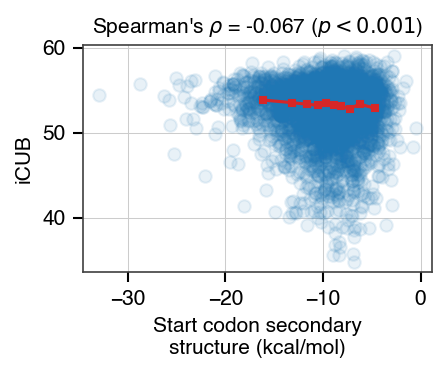

In [13]:
###TOGGLE ME DEPENDING ON WHAT YOU WANT TO SHOW
# temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
# temp_df = combined_df[combined_df['trans_eff'].isnull()==False]
# temp_df = combined_df[combined_df['coding_sequence'].str.len()>150]
temp_df = combined_df[(combined_df['prot_abundance'].isnull()==False)&(combined_df['coding_sequence'].str.len()>150)]

# temp_df = combined_df
#
#
#
x_col = 'secondary_structure' ###CHANGE ME
x_label = col_to_label_dict[x_col]
#
y_col = 'iCUB' ###CHANGE ME
y_label = col_to_label_dict[y_col]
#
save_file = '/Ecoli_{}_v_{}.png'.format(x_col, y_col) ###Include beginning slash 
#
#
#
rho, p = stats.spearmanr(temp_df[x_col], temp_df[y_col])
fig, ax = plt.subplots(figsize=(3, 2))
if y_col in ['prot_abundance', 'trans_eff']:
    ax.semilogy(temp_df[x_col], temp_df[y_col], 'o', alpha=0.1)
else:
    ax.plot(temp_df[x_col], temp_df[y_col], 'o', alpha=0.1)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
if p < 10e-4:
    ax.set_title(r"Spearman's $\rho$ = {:.3f} ($p<0.001$)".format(rho))
else:
    ax.set_title(r"Spearman's $\rho$ = {:.3f} ($p={:.3f}$)".format(rho,p))
#
###Adding in a trendline
temp_df['quantiles'] = pd.qcut(temp_df[x_col], q=10, precision=5, labels=np.arange(1,11,1))
x_trend = []
y_trend = []
for i in np.arange(1,11,1):
    x_trend.append(temp_df[temp_df['quantiles']==i][x_col].median())
    y_trend.append(temp_df[temp_df['quantiles']==i][y_col].median())
plt.plot(x_trend, y_trend, 's-', markersize=3, color=colors[3])
plt.savefig(figs_dir+save_file, dpi=300, bbox_inches='tight')
print('Spearman correlation:', rho, p)

**Plotting combined models**

/Users/adamhockenberry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/adamhockenberry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Spearman correlation: 0.17114451529546226 7.173172969301405e-25


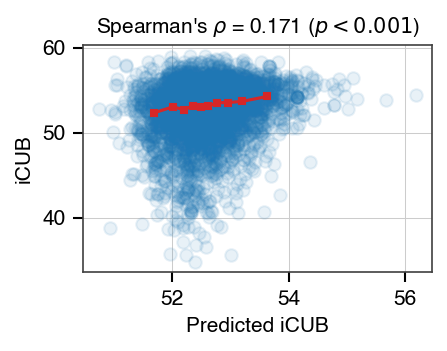

In [17]:
###TOGGLE ME
# temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
# temp_df = combined_df[(combined_df['trans_eff'].isnull()==False)]
# temp_df = combined_df[combined_df['coding_sequence'].str.len()>150]
temp_df = combined_df[(combined_df['coding_sequence'].str.len()>150) & (combined_df['prot_abundance'].isnull()==False)]
# temp_df = combined_df[(combined_df['coding_sequence'].str.len()>150) & (combined_df['trans_eff'].isnull()==False)]


# temp_df = combined_df
#
#
y_col = 'iCUB' ###CHANGE ME
if y_col != 'iCUB':
    x_label = 'Predicted {}'.format(col_to_label_dict[y_col].lower())
else:
    x_label = 'Predicted {}'.format(col_to_label_dict[y_col])
y_label = col_to_label_dict[y_col]
#
save_file = '/Ecoli_{}_v_combined.png'.format(y_col) ###Include beginning slash 
#
#
#
if y_col in ['prot_abundance', 'trans_eff']:
    model = smf.ols('np.log({}) ~ RBS_energy + secondary_structure'.format(y_col), data=temp_df).fit()
    temp_df['combined'] = np.exp(model.predict(temp_df))
else:
    model = smf.ols('{} ~ RBS_energy + secondary_structure'.format(y_col), data=temp_df).fit()
    temp_df['combined'] = model.predict(temp_df)


rho, p = stats.spearmanr(temp_df['combined'], temp_df[y_col])
fig, ax = plt.subplots(figsize=(3, 2))
if y_col in ['prot_abundance', 'trans_eff']:
    ax.loglog(temp_df['combined'], temp_df[y_col], 'o', alpha=0.1)
else:
    ax.plot(temp_df['combined'], temp_df[y_col], 'o', alpha=0.1)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
if p < 10e-4:
    ax.set_title(r"Spearman's $\rho$ = {:.3f} ($p<0.001$)".format(rho))
else:
    ax.set_title(r"Spearman's $\rho$ = {:.3f} ($p={:.3f}$)".format(rho,p))
#
temp_df['quantiles'] = pd.qcut(temp_df['combined'], q=10, precision=5, labels=np.arange(1,11,1))
x_trend = []
y_trend = []
for i in np.arange(1,11,1):
    x_trend.append(temp_df[temp_df['quantiles']==i]['combined'].median())
    y_trend.append(temp_df[temp_df['quantiles']==i][y_col].median())
ax.plot(x_trend, y_trend, 's-', markersize=3, color=colors[3])

plt.savefig(figs_dir+save_file, dpi=300, bbox_inches='tight')
print('Spearman correlation:', rho, p)

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   iCUB   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     55.14
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           2.60e-24
Time:                        12:18:45   Log-Likelihood:                -9402.5
No. Observations:                3570   AIC:                         1.881e+04
Df Residuals:                    3567   BIC:                         1.883e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              52.6284      0.184    286.547      0.000      52.268      52.988
RBS_energy              0.2502      0.027      9.351      0.000       0.198       0.303
secondary_structure    -0.1209      0.017     -7.281      0.000      -0.154      -0.088
==============================================================================
Omnibus:                      850.930   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2030.455
Skew:                          -1.316   Prob(JB):                         0.00
Kurtosis:                       5.593   Cond. No.                         37.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
print(stats.spearmanr(temp_df['secondary_structure'], temp_df['trans_eff']))

SpearmanrResult(correlation=nan, pvalue=nan)


**Boxplots comparing gene essentiality**

Kruskal-Wallis: 1.087180297621243 0.5806598505087203


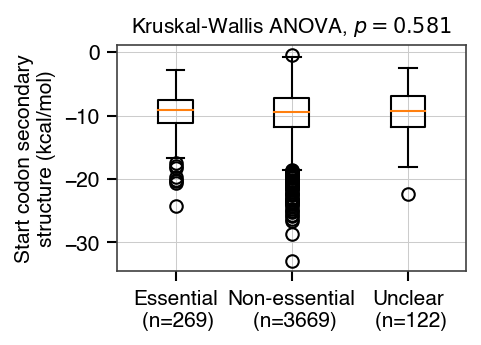

In [20]:
temp_df = combined_df
# temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
# temp_df = combined_df[combined_df['trans_eff'].isnull()==False]
#
y_col = 'secondary_structure'
y_label = col_to_label_dict[y_col]
#
save_file = '/Ecoli_essential_v_{}.png'.format(y_col) ###Include beginning slash 


cats = ['Essential', 'Non-essential', 'Unclear']
cat_labels = []
box_data = []
for cat in cats:
    tempy = temp_df[temp_df['essentiality']==cat][y_col]
    box_data.append(tempy)
    cat_labels.append(cat + '\n (n={})'.format(tempy.shape[0]))
fig, ax = plt.subplots(figsize=(3,2))
ax.boxplot(box_data);
ax.set_xticklabels(cat_labels)
ax.set_ylabel(y_label)
if y_col in ['prot_abundance', 'trans_eff']:
    ax.set_yscale('log')
#
stat, p = stats.kruskal(*box_data)
if p < 10e-4:
    ax.set_title(r"Kruskal-Wallis ANOVA, $p<0.001$".format(p))
else:
    ax.set_title(r"Kruskal-Wallis ANOVA, $p={:.3f}$".format(p))
    
plt.savefig(figs_dir+save_file, dpi=300, bbox_inches='tight')
print('Kruskal-Wallis:', stat, p)


## Example comparison between host and phage

**Note that T7 id in this database is: 7841 and I'm using the predicted annotations here**

In [21]:
virus_df = pd.read_csv('../Data/562_rep_viruses/7841.clean.tsv', sep='\t', index_col=0)
print(virus_df.shape)
virus_df.head()

(49, 19)


,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,upstream_sequence,RBS_energy,RBS_energy_upstream,iCUB,GC_cds,GC_upstream,viral_id,secondary_structure,secondary_structure_internal
0,NC_001604|10760,Prodigal_v2.6.3,CDS,925,1278,64.7,+,0,ID=347_1;partial=00;start_type=ATG;rbs_motif=G...,ATGGCTATGTCTAACATGACTTACAACAACGTTTTCGACCACGCTT...,TTCACTAATAACTGCACGAGGTAACACAAG,-5.42,-0.34,50.525906,0.468927,0.400000,347_1,-5.17,-11.35
1,NC_001604|10760,Prodigal_v2.6.3,CDS,1278,1433,17.1,+,0,ID=347_2;partial=00;start_type=ATG;rbs_motif=A...,ATGTCTACTACCAACGTGCAATACGGTCTGACCGCTCAAACTGTAC...,AGTCGAGGAGTACGAGGAGGATGAAGAGTA,-9.31,-6.36,43.066882,0.455128,0.500000,347_2,-10.17,-13.10
2,NC_001604|10760,Prodigal_v2.6.3,CDS,1496,1639,13.3,+,0,ID=347_3;partial=00;start_type=ATG;rbs_motif=G...,ATGTATATGCTTACTATCGGTCTACTCACCGCTCTAGGTCTAGCTG...,TATGATTATCACTTTACTTATGAGGGAGTA,-5.82,-0.00,39.155014,0.458333,0.300000,347_3,-8.15,-15.63
3,NC_001604|10760,Prodigal_v2.6.3,CDS,1636,1797,8.1,+,0,ID=347_4;partial=00;start_type=ATG;rbs_motif=G...,ATGATGAAGCACTACGTTATGCCAATCCACACGTCCAACGGGGCAA...,CATAGGAATCATCAAAGGGGCACTACGCAA,-5.53,-3.45,42.406008,0.481481,0.466667,347_4,-10.08,-12.54
4,NC_001604|10760,Prodigal_v2.6.3,CDS,2021,3100,118.8,+,0,ID=347_5;partial=00;start_type=ATG;rbs_motif=A...,ATGAACATTACCGACATCATGAACGCTATCGACGCAATCAAAGCAC...,TCTCATAACGAACATAAAGGACACAATGCA,-4.00,-0.51,55.711182,0.493519,0.366667,347_5,-2.19,-13.09


**Statistical differences in single variables between virus and host with a few different ways to slice host genes. Using ranksums to be conservative on significance here temporarily.**

In [22]:
col_name = 'RBS_energy'
#
temp_df = combined_df
print('All data:', stats.ranksums(virus_df[col_name], temp_df[col_name]))
print('Means (virus, host):', np.mean(virus_df[col_name]), np.mean(temp_df[col_name]))
print()
#
temp_df = combined_df[combined_df['essentiality']=='Essential']
print('Essential dataset:', stats.ranksums(virus_df[col_name], temp_df[col_name]))
print('Means (virus, host):', np.mean(virus_df[col_name]), np.mean(temp_df[col_name]))
print()
#
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
percentile_val = np.percentile(temp_df['prot_abundance'], 50)
temp_df = temp_df[temp_df['prot_abundance']>=percentile_val]
print('Top 50 protein abundance:', stats.ranksums(virus_df[col_name], temp_df[col_name]))
print('Means (virus, host):', np.mean(virus_df[col_name]), np.mean(temp_df[col_name]))
print()
#
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
percentile_val = np.percentile(temp_df['prot_abundance'], 75)
temp_df = temp_df[temp_df['prot_abundance']>=percentile_val]
print('Top 25 protein abundance:', stats.ranksums(virus_df[col_name], temp_df[col_name]))
print('Means (virus, host):', np.mean(virus_df[col_name]), np.mean(temp_df[col_name]))
print()

All data: RanksumsResult(statistic=-8.10720355307069, pvalue=5.179804609502637e-16)
Means (virus, host): -7.52408163265306 -4.766135467980333

Essential dataset: RanksumsResult(statistic=-8.089479769348781, pvalue=5.992010540962595e-16)
Means (virus, host): -7.52408163265306 -4.461078066914501

Top 50 protein abundance: RanksumsResult(statistic=-7.804046450273147, pvalue=5.99531090659335e-15)
Means (virus, host): -7.52408163265306 -4.975553691275162

Top 25 protein abundance: RanksumsResult(statistic=-7.328589760322209, pvalue=2.325871605285187e-13)
Means (virus, host): -7.52408163265306 -5.242203579418331



**Switching to a logistic regression framework to assess significance since it's more extensible. Essentially this asks the question: to what degree are various x-values useful for predicting whether a gene came from the virus or the host?**

In [23]:
assert len(list(combined_df['genome_id'].value_counts().keys())) == 1
host_name = combined_df['genome_id'].value_counts().keys()[0]
#
concat_df = pd.concat((combined_df, virus_df), ignore_index=True, sort=False)
concat_df['binary_predictor'] = 1
concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
#
fitted = smf.logit('binary_predictor ~ RBS_energy', data=concat_df).fit(disp=0)
print(fitted.summary())
print('##############################################################################')
print('##############################################################################')
#
fitted = smf.logit('binary_predictor ~ secondary_structure', data=concat_df).fit(disp=0)
print(fitted.summary())
print('##############################################################################')
print('##############################################################################')
#
fitted = smf.logit('binary_predictor ~ RBS_energy + secondary_structure', data=concat_df).fit(disp=0)
print(fitted.summary())
print('##############################################################################')
print('##############################################################################')
fitted = smf.logit('binary_predictor ~ RBS_energy + secondary_structure + GC_upstream', data=concat_df).fit(disp=0)
print(fitted.summary())
print('##############################################################################')
print('##############################################################################')
fitted = smf.logit('binary_predictor ~ RBS_energy + secondary_structure + GC_upstream + iCUB', data=concat_df).fit(disp=0)
print(fitted.summary())

                           Logit Regression Results                           
Dep. Variable:       binary_predictor   No. Observations:                 4109
Model:                          Logit   Df Residuals:                     4107
Method:                           MLE   Df Model:                            1
Date:                Wed, 25 Mar 2020   Pseudo R-squ.:                  0.1540
Time:                        12:19:12   Log-Likelihood:                -224.81
converged:                       True   LL-Null:                       -265.73
Covariance Type:            nonrobust   LLR p-value:                 1.464e-19
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.6537      0.654    -13.235      0.000      -9.935      -7.372
RBS_energy    -0.6763      0.085     -7.928      0.000      -0.843      -0.509
####################################################

**Visualize those results**

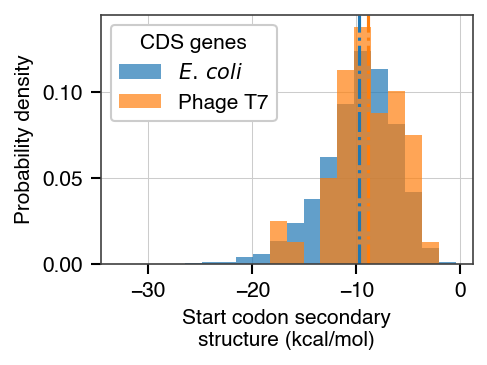

In [25]:
col_name = 'secondary_structure'
temp_df = combined_df

# temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
# percentile_val = np.percentile(temp_df['prot_abundance'], 50)
# temp_df = temp_df[temp_df['prot_abundance']>=percentile_val]

a, b = np.histogram(np.concatenate((temp_df[col_name].values, virus_df[col_name].values)), 20)

fig, ax = plt.subplots(figsize=(3.2,2.2))
ax.hist(temp_df[col_name], bins=b, label='$E.\, coli$', density=True, alpha=0.7)
ax.hist(virus_df[col_name], bins=b, label='Phage T7', density=True, alpha=0.7)
ax.axvline(temp_df[col_name].mean(), color=colors[0], linestyle='-.')
ax.axvline(virus_df[col_name].mean(), color=colors[1], linestyle='-.')
ax.set_xlabel(col_to_label_dict[col_name])
ax.set_ylabel('Probability density')
plt.legend(title='CDS genes', framealpha=1.0)
plt.savefig(figs_dir + '/Ecoli_T7_{}.png'.format(col_name), dpi=300, bbox_inches='tight')

**Relationship between these two using a random effects model**

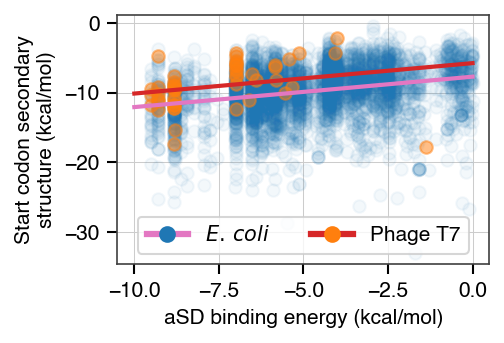

In [92]:
x_col = 'RBS_energy'
y_col = 'secondary_structure'

fig, ax = plt.subplots(figsize=(3.2,2.2))
ax.plot(temp_df[x_col], temp_df[y_col], marker='o', linestyle='', color=colors[0], alpha=0.05)
ax.plot(virus_df[x_col], virus_df[y_col], marker='o', linestyle='', color=colors[1], alpha=0.5)
#
#
#
###Drawing lines from a mixed linear model
concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False) 
fitted = smf.mixedlm('{} ~ {}'.format(y_col, x_col), data=concat_df,\
                      groups=concat_df['genome_id']).fit()
x_vals = np.linspace(-10, 0, 11)
tempy = pd.DataFrame(x_vals, columns=[x_col])
ax.plot(x_vals, fitted.predict(tempy)+fitted.random_effects[temp_df['genome_id'][0]][0],\
        color=colors[6], linewidth=2)
ax.plot(x_vals, fitted.predict(tempy)+fitted.random_effects[virus_df['genome_id'][0]][0],\
        color=colors[3], linewidth=2)
#
#
#Cleaning up the legend
ax.plot([], [], linestyle='-', linewidth=3, color = colors[6],\
        marker='o', markersize=7, markerfacecolor=colors[0], markeredgecolor=colors[0], label='$E.\, coli$')
ax.plot([], [], linestyle='-', linewidth=3, color = colors[3],\
        marker='o', markersize=7, markerfacecolor=colors[1], markeredgecolor=colors[1], label='Phage T7')

leg = plt.legend(ncol=2, loc=8)
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
ax.set_xlabel(col_to_label_dict[x_col])
ax.set_ylabel(col_to_label_dict[y_col])
plt.savefig(figs_dir + '/Ecoli_T7_biplot.png'.format(col_name), dpi=300, bbox_inches='tight')

In [93]:
print('Host:', stats.spearmanr(temp_df[y_col], fitted.predict(pd.DataFrame(temp_df[x_col], columns=['RBS_energy']))))
print('Virus:', stats.spearmanr(virus_df[y_col], fitted.predict(pd.DataFrame(virus_df[x_col], columns=['RBS_energy']))))

Host: SpearmanrResult(correlation=0.29454171949254526, pvalue=4.5635100916844394e-82)
Virus: SpearmanrResult(correlation=0.4845485519471713, pvalue=0.000418626374126898)


# Extended analysis to many *E. coli* viruses

**Starting with analyzing all E. coli genes**

In [28]:
col_name = 'secondary_structure'
temp_df = combined_df
host_mean = temp_df[col_name].mean()
###For the violin plot at the top
mean_virus = []
p_vals = []
for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    mean_virus.append(virus_df[col_name].mean())
    
    concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
    concat_df['binary_predictor'] = 1
    concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
    fitted = smf.logit('binary_predictor ~ {}'.format(col_name), data=concat_df).fit(disp=0)
    p_vals.append(fitted.pvalues[1])
truth_array, correct_p_vals = multi.fdrcorrection(p_vals, alpha=0.01)
#
#
#
zippy = list(zip(p_vals, mean_virus))
lside = len([1 for i,j in zippy if i < 0.01 and j < host_mean])
rside = len([1 for i,j in zippy if i < 0.01 and j >= host_mean])
print('N significant no FDR (total={}):'.format(len(p_vals)), lside, rside)
#
zippy = list(zip(correct_p_vals, mean_virus))
lside = len([1 for i,j in zippy if i < 0.01 and j < host_mean])
rside = len([1 for i,j in zippy if i < 0.01 and j >= host_mean])
print('N significant w/ FDR(total={}):'.format(len(p_vals)), lside, rside)


N significant no FDR (total=373): 247 24
N significant w/ FDR(total=373): 239 24


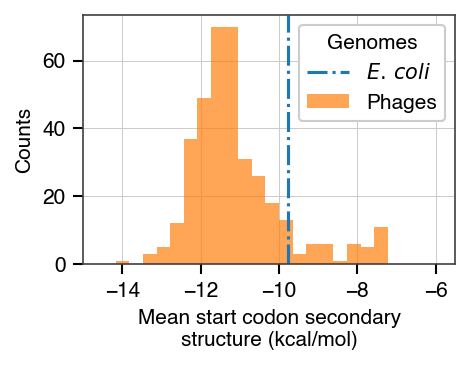

In [30]:
fig, ax = plt.subplots(figsize=(3.2,2.2))
ax.hist(mean_virus, 20, color=colors[1], label='Phages', alpha=0.7)
ax.axvline(temp_df[col_name].mean(), color=colors[0], linestyle='-.', label='$E.\, coli$')
ax.set_ylabel('Counts')
ax.set_xlabel(mean_col_to_label_dict[col_name])
plt.legend(title='Genomes', framealpha=1.0)
# ax.set_xlim(-15, -5.5)
plt.savefig(figs_dir + '/Ecoli_allphage_{}.png'.format(col_name), dpi=300, bbox_inches='tight')

**Stratifying E. coli genes into some different categories to get a better intuition**

In [33]:
col_name = 'secondary_structure'

###For the violin plot at the top
mean_virus = []
for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    mean_virus.append(virus_df[col_name].mean())
    
###For all the host information    
host_df_list = []
host_df_list.append(combined_df)
percentiles_to_test = [25, 50, 75, 90, 95]
for i in percentiles_to_test:
    temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
    percentile_thresh = np.percentile(temp_df['prot_abundance'], i)
    host_df_list.append(temp_df[temp_df['prot_abundance']>=percentile_thresh])
host_df_list.append(combined_df[(combined_df['essentiality']=='Essential')])
host_df_list.append(combined_df[(combined_df['essentiality']=='Non-essential')])
#
host_means = [temp_df[col_name].mean() for temp_df in host_df_list]
host_errs = [temp_df[col_name].std()/np.sqrt(temp_df.shape[0]) for temp_df in host_df_list]

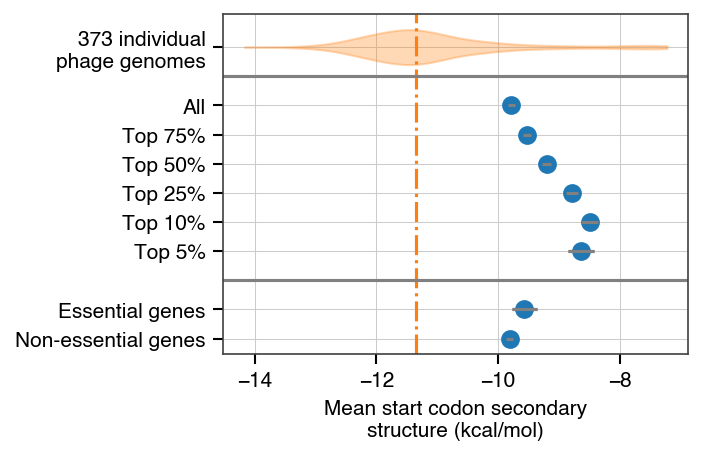

In [34]:
###Plotting
all_y_vals = list(np.arange(0, -(len(percentiles_to_test)+1)/2, -0.5))
highest = all_y_vals[-1]
all_y_vals = all_y_vals + list(np.arange(highest-1.0, highest-2.0, -0.5))

fig, ax = plt.subplots(figsize=(4,3))
vparts = ax.violinplot([mean_virus], widths=0.6, vert=False, showextrema=False, points=100)
for pc in vparts['bodies']:
    pc.set_facecolor(colors[1])
    pc.set_edgecolor(colors[1])
ax.axvline(np.median(mean_virus), c=colors[1], linestyle='-.')
ax.axhline(0.5, c='gray')
#Plotting two here to hack the line/dot overlaps
ax.errorbar(host_means, all_y_vals, xerr=host_errs,\
            marker='o', linestyle='', mfc=colors[0], mec=colors[0], ecolor='gray',\
            zorder=1, markersize=8)
ax.errorbar(host_means, all_y_vals, xerr=host_errs,\
            marker='', linestyle='', mfc=colors[0], mec=colors[0], ecolor='gray',\
            zorder=2, markersize=8)
#
ax.axhline(-3, c='gray')
ax.set_xlabel(mean_col_to_label_dict[col_name])
ax.set_yticks([1]+all_y_vals)
ax.set_yticklabels(['373 individual\nphage genomes',\
                    'All',\
                    'Top 75%',\
                    'Top 50%',\
                    'Top 25%',\
                    'Top 10%',\
                    'Top 5%',\
                    'Essential genes',\
                    'Non-essential genes']);
plt.savefig(figs_dir + '/Ecoli_{}_categories.png'.format(col_name), dpi=300, bbox_inches='tight')

**And getting statistics for all those comparisons**

In [65]:
assert len(list(combined_df['genome_id'].value_counts().keys())) == 1
host_name = combined_df['genome_id'].value_counts().keys()[0]
#
results = []
for temp_df in host_df_list:
    beta_vals = []
    p_vals = []
    for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
        virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
        concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
        concat_df['binary_predictor'] = 1
        concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
        fitted = smf.logit('binary_predictor ~ {}'.format(col_name), data=concat_df).fit(disp=0)
        beta_vals.append(fitted.params[1])
        p_vals.append(fitted.pvalues[1])
    truth_array, correct_p_vals = multi.fdrcorrection(p_vals, alpha=0.01)
    zippy = list(zip(correct_p_vals, beta_vals))
    lside = len([1 for i,j in zippy if i < 0.01 and j < 0])
    rside = len([1 for i,j in zippy if i < 0.01 and j >= 0])
    results.append((lside, rside))

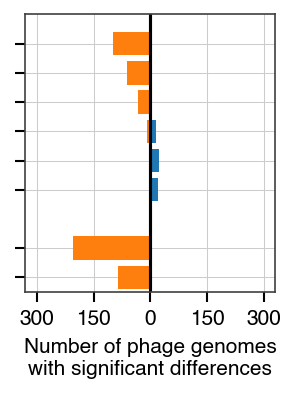

In [66]:
fig, ax = plt.subplots(figsize=(2.15,2.45))
l_bar = ax.barh(all_y_vals, [-1*i[0] for i in results], height=0.4,\
             color=colors[1], left=[i[1] for i in results])
r_bar = ax.barh(all_y_vals, [i[1] for i in results], height=0.4,\
            color=colors[0])
ax.set_yticklabels('')
ax.set_xticks([-300, -150, 0, 150, 300])
ax.set_xticklabels([300, 150, 0, 150, 300])
ax.set_xlim(-330, 330)
ax.axvline(0, c='k')
ax.set_yticks(all_y_vals[::-1])
ax.set_ylim(-4.25, 0.5)

ax.set_xlabel('Number of phage genomes\nwith significant differences')
plt.savefig(figs_dir + '/Ecoli_{}_categories_bar.png'.format(col_name), dpi=300, bbox_inches='tight')

**Looking at more than a single-variable at a time**

In [99]:
taxon_id = '562'
host_df = pd.read_csv('../Data/host_genomes/{}.clean.tsv'.format(taxon_id), sep='\t', index_col=0)

lifestyle_df = pd.read_csv('../Data/lifestyle_results_{}.tsv'.format(taxon_id), sep='\t', index_col=1)
lifestyle_df = lifestyle_df.drop('Unnamed: 0', axis=1)
lifestyle_df.head()

,1,2
0,,
1085,Temperate,0.512288
2135,Temperate,0.567532
747,Temperate,0.584016
4516,Temperate,0.564535
11438,Temperate,0.574426


In [118]:
assert len(list(combined_df['genome_id'].value_counts().keys())) == 1
host_name = combined_df['genome_id'].value_counts().keys()[0]
temp_df = combined_df
t_vals_a = []
t_vals_b = []
p_vals_a = []
p_vals_b = []
lifestyle_vals = []
for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
#     if '7841' not in virus_tsv:
#         continue
    vir_name = virus_tsv.split('/')[-1].split('.clean.tsv')[0]
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    if lifestyle_df.loc[int(vir_name)][1] < 0.55:
        continue
    lifestyle_vals.append(lifestyle_df.loc[int(vir_name)][0])   
    concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
    concat_df['binary_predictor'] = 1
    concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
#     fitted = smf.logit('binary_predictor ~ RBS_energy', data=concat_df).fit(disp=0)
#     fitted = smf.logit('binary_predictor ~ RBS_energy + GC_upstream', data=concat_df).fit(disp=0)
    fitted = smf.logit('binary_predictor ~ RBS_energy + secondary_structure', data=concat_df).fit(disp=0)
#     fitted = smf.logit('binary_predictor ~ secondary_structure', data=concat_df).fit(disp=0)
#     fitted = smf.logit('binary_predictor ~ RBS_energy + secondary_structure + GC_cds + iCUB', data=concat_df).fit(disp=0)
#     beta_vals_a.append(fitted.params[1])
#     beta_vals_b.append(fitted.params[2])
    #
    t_vals_a.append(fitted.tvalues[1])
    t_vals_b.append(fitted.tvalues[2])
    #
    p_vals_a.append(fitted.pvalues[1])
    p_vals_b.append(fitted.pvalues[2])

In [119]:
truth_array, correct_p_vals_a = multi.fdrcorrection(p_vals_a, alpha=0.01)
print(np.sum(truth_array))
truth_array, correct_p_vals_b = multi.fdrcorrection(p_vals_b, alpha=0.01)
print(np.sum(truth_array))

31
145


In [129]:
a_boundaries = []
for i, j in zip(t_vals_a, correct_p_vals_a):
    if j >= 0.01:
        a_boundaries.append(i)
a_max = max(a_boundaries)
a_min = min(a_boundaries)
a_bound = max([abs(a_max), abs(a_min)])
for i, j in zip(t_vals_a, correct_p_vals_a):
    if j < 0.01:
        assert abs(i) > a_bound
        
b_boundaries = []
for i, j in zip(t_vals_b, correct_p_vals_b):
    if j >= 0.01:
        b_boundaries.append(i)
b_max = max(b_boundaries)
b_min = min(b_boundaries)
b_bound = max([abs(b_max), abs(b_min)])
for i, j in zip(t_vals_b, correct_p_vals_b):
    if j < 0.01:
        assert abs(i) > b_bound
        
print(a_bound, b_bound)

3.0519579235041476 2.7158759798741805


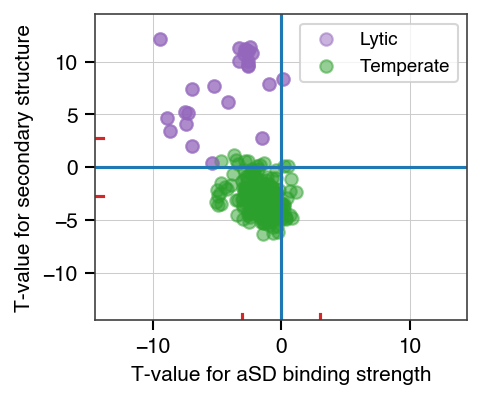

In [130]:
# fig, ax = plt.subplots()
# ax.scatter(np.exp(np.array(beta_vals_a)), np.exp(beta_vals_b))
# ax.plot([0.5, 1.4], [1.4, 0.5])
fig, ax = plt.subplots(figsize=(3.2,2.7))
# ax.plot(t_vals_a, t_vals_b, marker='o', linestyle='', c=colors[1], alpha=0.5)

ax.scatter([i for i,j in zip(t_vals_a, lifestyle_vals) if j=='Lytic'],\
           [i for i,j in zip(t_vals_b, lifestyle_vals) if j=='Lytic'],\
           c=colors[4], alpha=0.5, label='Lytic')
ax.scatter([i for i,j in zip(t_vals_a, lifestyle_vals) if j=='Temperate'],\
           [i for i,j in zip(t_vals_b, lifestyle_vals) if j=='Temperate'],\
           c=colors[2], alpha=0.5, label='Temperate')

ax.scatter([i for i,j in zip(t_vals_a, lifestyle_vals) if j=='Lytic'],\
           [i for i,j in zip(t_vals_b, lifestyle_vals) if j=='Lytic'],\
           c=colors[4], alpha=0.5)


# ax.axvline(-a_bound, c=colors[3], linestyle='--')
# ax.axvline(a_bound, c=colors[3], linestyle='--')
# ax.axhline(-b_bound, c=colors[3], linestyle='--')
# ax.axhline(b_bound, c=colors[3], linestyle='--')
ax.axvline(-a_bound, ymax=0.02, c=colors[3])
ax.axvline(a_bound, ymax=0.02, c=colors[3])
ax.axhline(-b_bound, xmax=0.02, c=colors[3])
ax.axhline(b_bound, xmax=0.02, c=colors[3])
# ax.axvspan(-a_bound, a_bound, color='k', alpha=0.3)
# ax.axhspan(-b_bound, b_bound, xmax=0.393, color='k', alpha=0.3)
# ax.axhspan(-b_bound, b_bound, xmax=0.393, color='k', alpha=0.3)


# for i, j, k, l in zip(t_vals_a, correct_p_vals_a, t_vals_b, correct_p_vals_b):
#     if j < 0.01 and l < 0.01:
#         ax.plot([i], [k], marker='o', linestyle='', c=colors[1], alpha=0.5)
#     else:
#         ax.plot([i], [k], marker='o', linestyle='', c='k', alpha=0.5)
# ax.scatter([i for i,j in zip(beta_vals_a, lifestyle_vals) if j=='Temperate'],\
#            [i for i,j in zip(beta_vals_b, lifestyle_vals) if j=='Temperate'], c=colors[2])
# ax.scatter([i for i,j in zip(beta_vals_a, lifestyle_vals) if j=='Lytic'],\
#            [i for i,j in zip(beta_vals_b, lifestyle_vals) if j=='Lytic'], c=colors[4])
ax.axvline(0, c=colors[0])
ax.axhline(0, c=colors[0])
ax.set_xlim(-14.5, 14.5)
ax.set_ylim(-14.5, 14.5)
plt.legend(loc=1, fontsize=9)
ax.set_xlabel('T-value for aSD binding strength')
ax.set_ylabel('T-value for secondary structure')
plt.savefig(figs_dir + '/Ecoli_{}_tval_scatter.png'.format(col_name), dpi=300, bbox_inches='tight')

In [ ]:
fitted.summary()

# Multi-level modeling solution

In [ ]:
concat_df = combined_df
concat_df['vir_name'] = 'host'
for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
    vir_name = virus_tsv.split('/')[-1].split('.clean.tsv')[0]
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    virus_df['vir_name'] = vir_name
    concat_df = pd.concat((concat_df, virus_df), ignore_index=True, sort=False)

In [ ]:
###Random intercept model
mixed_lm_md = smf.mixedlm('secondary_structure ~ RBS_energy', concat_df,\
                 groups=concat_df['vir_name']).fit()
###Random slope model
# mixed_lm_md = smf.mixedlm('secondary_structure ~ RBS_energy', concat_df,\
#                  re_formula='0+RBS_energy', groups=concat_df['vir_name']).fit()
###Random intercept and random slope model
# mixed_lm_md = smf.mixedlm('secondary_structure ~ RBS_energy', concat_df,\
#                  re_formula='RBS_energy', groups=concat_df['vir_name']).fit()

In [ ]:
re_dict = mixed_lm_md.random_effects
non_host = []
for key, val in re_dict.items():
    if key == 'host':
        host_re = val[0]
        print('found host')
    else:
        non_host.append(val[0])
        
fig, ax = plt.subplots()
ax.hist(non_host, bins=20, color=colors[1], alpha=0.5, label='Phages')
ax.axvline(host_re, color=colors[0], label='E. coli')
plt.legend(title='Random effect value')

In [ ]:
re_dict = mixed_lm_md.random_effects
non_host_lytic = []
non_host_temperate = []
for key, val in re_dict.items():
    if key == 'host':
        host_re = val[0]
        print('found host')
    else:
        if lifestyle_df.loc[int(key)][1] < 0.55:
            continue
        if lifestyle_df.loc[int(key)][0] == 'Lytic': 
            non_host_lytic.append(val[0])
        elif lifestyle_df.loc[int(key)][0] == 'Temperate': 
            non_host_temperate.append(val[0])
trash, bins = np.histogram(np.concatenate((non_host_lytic, non_host_temperate)), 20)        
fig, ax = plt.subplots()
ax.hist(non_host_lytic, bins=bins, color=colors[2], alpha=0.5, label='Temperate phages')
ax.hist(non_host_temperate, bins=bins, color=colors[4], alpha=0.5, label='Lytic phages')
ax.axvline(host_re, color=colors[0], label='E. coli')
plt.legend(title='Random effect value')

In [ ]:
temp_df = combined_df
lside = 0
rside = 0
attempts = 0
for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
    attempts += 1
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    concat_df = pd.concat((combined_df, virus_df), ignore_index=True, sort=False)
    concat_df['binary_predictor'] = 1
    concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
#     fitted = smf.logit('binary_predictor ~ RBS_energy', data=concat_df).fit(disp=0)
    fitted = smf.logit('binary_predictor ~ RBS_energy + secondary_structure', data=concat_df).fit(disp=0)
    if fitted.pvalues[1] < 0.01:
        if fitted.params[1] < 0:
            lside += 1
        elif fitted.params[1] > 0:
            rside += 1
print(attempts, lside, rside)

# Significance using a stricter set of independent viruses

In [ ]:
independent_set = []
with open('../Data/independent_set.txt', 'r') as infile:
    for line in infile:
        independent_set.append(line.split('/')[-1].split('.fasta')[0])
print(independent_set[:5])

In [ ]:
col_name = 'secondary_structure'
###For the violin plot at the top
mean_virus = []
for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
    if virus_tsv.split('/')[-1].split('.clean.tsv')[0] not in independent_set:
        continue
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    mean_virus.append(virus_df[col_name].mean())
    
###For all the host information    
host_df_list = []
host_df_list.append(combined_df)
percentiles_to_test = [25, 50, 75, 90, 95]
for i in percentiles_to_test:
    temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
    percentile_thresh = np.percentile(temp_df['prot_abundance'], i)
    host_df_list.append(temp_df[temp_df['prot_abundance']>=percentile_thresh])
host_df_list.append(combined_df[(combined_df['essentiality']=='Essential')])
host_df_list.append(combined_df[(combined_df['essentiality']=='Non-essential')])
#
host_means = [temp_df[col_name].mean() for temp_df in host_df_list]
host_errs = [temp_df[col_name].std()/np.sqrt(temp_df.shape[0]) for temp_df in host_df_list]

In [ ]:
###Plotting
all_y_vals = list(np.arange(0, -(len(percentiles_to_test)+1)/2, -0.5))
highest = all_y_vals[-1]
all_y_vals = all_y_vals + list(np.arange(highest-1.0, highest-2.0, -0.5))

fig, ax = plt.subplots(figsize=(4,3))
vparts = ax.violinplot([mean_virus], widths=0.6, vert=False, showextrema=False, points=100)
for pc in vparts['bodies']:
    pc.set_facecolor(colors[1])
    pc.set_edgecolor(colors[1])
ax.axvline(np.median(mean_virus), c=colors[1], linestyle='-.')
ax.axhline(0.5, c='gray')
#
ax.errorbar(host_means, all_y_vals, xerr=host_errs,\
            marker='o', linestyle='', mfc=colors[0], mec=colors[0], ecolor='gray',\
            zorder=1, markersize=8)
ax.axhline(-3, c='gray')
ax.set_xlabel(col_to_label_dict[col_name])
ax.set_yticks([1]+all_y_vals)
ax.set_yticklabels(['{} individual\nphage genomes'.format(len(mean_virus)),\
                    'All',\
                    'Top 75%',\
                    'Top 50%',\
                    'Top 25%',\
                    'Top 10%',\
                    'Top 5%',\
                    'Essential genes',\
                    'Non-essential genes']);
# plt.savefig(figs_dir + '/Ecoli_{}_categories.png'.format(col_name), dpi=300, bbox_inches='tight')

In [ ]:
results = []
for temp_df in host_df_list:
    lside = 0
    rside = 0
    for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
        if virus_tsv.split('/')[-1].split('.clean.tsv')[0] not in independent_set:
            continue
        virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
        rstat, pval = stats.ranksums(temp_df[col_name], virus_df[col_name])
        if pval < 0.01:
            if virus_df[col_name].mean() < temp_df[col_name].mean():
                lside += 1
            elif virus_df[col_name].mean() >= temp_df[col_name].mean():
                rside += 1
    results.append((-lside, rside))

In [ ]:
fig, ax = plt.subplots(figsize=(2.15,2.45))
p2 = ax.barh(all_y_vals, [i[0] for i in results], height=0.4,\
             color=colors[1], left=[i[1] for i in results])
p1 = ax.barh(all_y_vals, [i[1] for i in results], height=0.4,\
            color=colors[0])
ax.set_xlim(-250, 250)
ax.set_yticklabels('')
ax.set_xticks([-100, -50, 0, 50, 100])
ax.set_xticklabels([100, 50, 0, 50, 100])
ax.set_xlim(-100, 100)
ax.axvline(0, c='k')
ax.set_yticks(all_y_vals[::-1])
ax.set_ylim(-4.25, 0.5)

ax.set_xlabel('Number of phage genomes\nwith significant differences')
# plt.savefig(figs_dir + '/Ecoli_{}_categories_bar.png'.format(col_name), dpi=300, bbox_inches='tight')

# Separating phages according to predicted lifestyle

In [ ]:
taxon_id = '562'
host_df = pd.read_csv('../Data/host_genomes/{}.clean.tsv'.format(taxon_id), sep='\t', index_col=0)

lifestyle_df = pd.read_csv('../Data/lifestyle_results_{}.tsv'.format(taxon_id), sep='\t', index_col=1)
lifestyle_df = lifestyle_df.drop('Unnamed: 0', axis=1)
lifestyle_df.head()

In [ ]:
col_name = 'secondary_structure'
mean_lytic = []
mean_temperate = []
for virus_tsv in glob.glob('../Data/{}_rep_viruses/*.clean.tsv'.format(taxon_id))[:]:
    vir_name = virus_tsv.split('/')[-1].split('.clean.tsv')[0]
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
#     if lifestyle_df.loc[int(vir_name)][1] < 0.55:
#         continue
#     if vir_name not in independent_set:
#         continue
    if lifestyle_df.loc[int(vir_name)][0] == 'Temperate': 
        mean_temperate.append(virus_df[col_name].mean())
    elif lifestyle_df.loc[int(vir_name)][0] == 'Lytic': 
        mean_lytic.append(virus_df[col_name].mean())
    else:
        print('Uhho')


print(len(mean_lytic), len(mean_temperate), len(mean_lytic + mean_temperate))

In [ ]:
trash, bins = np.histogram(np.concatenate((mean_lytic, mean_temperate)), 20)
fig, ax = plt.subplots(figsize=(4, 2.75))
ax.hist(mean_lytic, bins=bins, density=True, alpha=0.8, color=colors[2], label='Lytic')
ax.hist(mean_temperate, bins=bins, density=True, alpha=0.8, color=colors[4], label='Temperate')
ax.axvline(combined_df[col_name].mean(), linestyle='--', color=colors[0], linewidth=2, label='Host')
plt.legend()
ax.set_xlabel(mean_col_to_label_dict[col_name])
ax.set_ylabel('Probability density')
# plt.savefig(figs_dir + '/Ecoli_phage_lifestyle.png', dpi=300, bbox_inches='tight')

In [ ]:
print(stats.ttest_ind(mean_lytic, mean_temperate))
print(stats.ranksums(mean_lytic, mean_temperate))

In [ ]:
virus_df

# Statistics accounting for various factors

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
metric = 'RBS_energy'

results_list = []
host_df = pd.read_csv('../Data/host_genomes/562.clean.tsv', sep='\t', index_col=0)
host_name = host_df['genome_id'].value_counts().keys()[0]

for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
#     if virus_tsv.split('/')[-1].split('.clean.tsv')[0] not in independent_set:
#         continue
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
#     if virus_df.shape[0] < 50 or virus_df.shape[0] > 200:
#         continue
    #
    results_ind = []
    results_ind.append(virus_tsv)
    #
    ttest_res = stats.ttest_ind(host_df[metric], virus_df[metric])
    results_ind.append(ttest_res[0])
    results_ind.append(ttest_res[1])
    #
    ranksums_res = stats.ranksums(host_df[metric], virus_df[metric])
    results_ind.append(ranksums_res[0])
    results_ind.append(ranksums_res[1])
    #
    concat_df = pd.concat((host_df, virus_df), ignore_index=True, sort=False)
    concat_df['binary_predictor'] = 1
    concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
    #
    fitted = smf.logit('binary_predictor ~ {}'.format(metric), data=concat_df).fit()
    results_ind.append(fitted.params[metric])
    results_ind.append(fitted.pvalues[metric])
    #
    fitted = smf.logit('binary_predictor ~ {} + iCUB + GC_upstream'.format(metric), data=concat_df).fit()
    results_ind.append(fitted.params[metric])
    results_ind.append(fitted.pvalues[metric])
    
    results_list.append(results_ind)

In [ ]:
results_df = pd.DataFrame(results_list)
results_df.columns = ['virus', 'ttest_stat', 'ttest_p',\
                     'ranksums_stat', 'ranksums_p',\
                     'logistic_coef', 'logistic_p',\
                     'logistic_full_coef', 'logistic_full_p']
results_df.set_index(results_df['virus'], inplace=True)
results_df = results_df.drop('virus', axis=1)
print(results_df.shape)
results_df.head()

In [ ]:
trash, bins = np.histogram(np.concatenate((results_df['logistic_coef'], results_df['logistic_full_coef'])))
fig, ax = plt.subplots()
ax.hist(results_df['logistic_coef'], bins=bins, alpha=0.5)
ax.hist(results_df['logistic_full_coef'], bins=bins, alpha=0.5)

In [ ]:
print('Total significant, virus stronger, host stronger:',\
      results_df[(results_df['logistic_p']<0.01)].shape[0],\
      results_df[(results_df['logistic_p']<0.01) & (results_df['logistic_coef']<0.)].shape[0],\
      results_df[(results_df['logistic_p']<0.01) & (results_df['logistic_coef']>=0.)].shape[0])

In [ ]:
print('Total significant, virus stronger, host stronger:',\
      results_df[(results_df['logistic_full_p']<0.01)].shape[0],\
      results_df[(results_df['logistic_full_p']<0.01) & (results_df['logistic_full_coef']<0.)].shape[0],\
      results_df[(results_df['logistic_full_p']<0.01) & (results_df['logistic_full_coef']>=0.)].shape[0])

In [ ]:
fig, ax = plt.subplots(figsize=(3,2))
ax.semilogy(results_df['logistic_coef'], results_df['logistic_p'], marker='o', linestyle='', alpha=0.5)
ax.axvline(0.0, c='k')
ax.axhline(0.01, c='r', linestyle='--')
ax.set_xlabel('Logistic regression coefficient')
ax.set_ylabel('$p$-value')
ax.set_xlim(-1.1, 0.4)
ax.set_xticks([-0.8, -0.4, 0, 0.4])
ax.set_ylim(10e-35, 100)

fig, ax = plt.subplots(figsize=(3,2))
ax.semilogy(results_df['logistic_full_coef'], results_df['logistic_full_p'], marker='o', linestyle='', alpha=0.5)
ax.axvline(0.0, c='k')
ax.axhline(0.01, c='r', linestyle='--')
ax.set_xlabel('Logistic regression coefficient')
ax.set_ylabel('$p$-value')
ax.set_xlim(-1.1, 0.4)
ax.set_xticks([-0.8, -0.4, 0, 0.4])
ax.set_ylim(10e-35, 100)




In [ ]:
import statsmodels.formula.api as smf

In [ ]:
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
fitted = smf.ols('np.log(prot_abundance) ~ RBS_energy + secondary_structure', data=temp_df).fit()
fitted.summary()

In [ ]:
fitted.weights

In [ ]:
temp_a = fitted.predict(combined_df)
temp_b = fitted.predict(virus_df)

In [ ]:
stats.ranksums(temp_a, temp_b), np.mean(temp_a), np.mean(temp_b)

In [ ]:
stats.ranksums(virus_df['RBS_energy'], temp_df['RBS_energy'])

In [ ]:
stats.ranksums(virus_df['secondary_structure'], temp_df['secondary_structure'])

In [ ]:
col_name = 'RBS_energy'

df_list = []
df_list.append(combined_df)

percentiles_to_test = [25, 50, 75, 90, 95]
for i in percentiles_to_test:
    temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
    percentile_thresh = np.percentile(temp_df['prot_abundance'], i)
    df_list.append(temp_df[temp_df['prot_abundance']>=percentile_thresh])

df_list.append(combined_df[(combined_df['essentiality']=='Essential')])
df_list.append(combined_df[(combined_df['essentiality']=='Non-essential')])

results = []
for temp_df in df_list:
    lside = 0
    rside = 0
    for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
        virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
        rstat, pval = stats.ranksums(temp_df[col_name], virus_df[col_name])
        if pval < 0.01:
            if virus_df[col_name].mean() < temp_df[col_name].mean():
                lside += 1
            elif virus_df[col_name].mean() >= temp_df[col_name].mean():
                rside += 1
    results.append((-lside, rside))

In [ ]:
results = results[::-1]

In [ ]:
results

In [ ]:
fig, ax = plt.subplots(figsize=(2,3))
p2 = ax.barh(all_y_vals, [i[0] for i in results], height=0.4, left=[i[1] for i in results])
p1 = ax.barh(all_y_vals, [i[1] for i in results], height=0.4)
ax.set_xlim(-250, 250)
ax.set_yticklabels('')
ax.set_xticks([-200, -100, 0, 100, 200])
ax.set_xticklabels([200, 100, 0, 100, 200])
ax.axvline(0, c='k')
ax.set_xlabel('Number of phage genomes\nwith significant differences')

In [ ]:
likert_colors = ['white', 'firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
dummy = pd.DataFrame([[1,2,3,4, 5], [5,6,7,8, 5], [10, 4, 2, 10, 5]],
                     columns=["SD", "D", "N", "A", "SA"],
                    index=["Key 1", "Key B", "Key III"])
middles = dummy[["SD", "D"]].sum(axis=1)+dummy["N"]*.5
longest = middles.max()
complete_longest = dummy.sum(axis=1).max()
dummy.insert(0, '', (middles - longest).abs())

dummy.plot.barh(stacked=True, color=likert_colors, edgecolor='none', legend=False)
z = plt.axvline(longest, linestyle='--', color='black', alpha=.5)
z.set_zorder(-1)

plt.xlim(0, complete_longest)
xvalues = range(0,complete_longest,10)
xlabels = [str(x-longest) for x in xvalues]
plt.xticks(xvalues, xlabels)
plt.show()

In [ ]:
dummy

In [ ]:
listy_temp = []
for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
    vir_name = virus_tsv.split('/')[-1].split('.clean.tsv')[0]
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    if lifestyle_df.loc[int(vir_name)][1] < 0.55:
        continue
#     if vir_name not in independent_set:
#         continue
    if lifestyle_df.loc[int(vir_name)][0] == 'Temperate':
        virus_df = virus_df[virus_df['secondary_structure_internal'].isnull()==False]
        listy_temp.append((virus_df['secondary_structure_internal']- virus_df['secondary_structure']).median())

In [ ]:
fig, ax = plt.subplots()
ax.hist(listy_temp)
ax.hist(listy_lyt)
ax.axvline(0.)
ax.axvline((temp_df['secondary_structure_internal']-temp_df['secondary_structure']).median())

In [19]:
from Bio import SeqIO
from Bio.Alphabet import generic_dna

In [21]:
# listy = list(SeqIO.parse('../../../Projects/bacphlip-py/bacphlip/data/example_data/genome_example.fasta', format='fasta'))
listy = list(SeqIO.parse('../../../Projects/bacphlip-py/bacphlip/data/example_data/genome_example.fasta.6frame',\
                         'fasta', generic_dna))

In [24]:
temp = listy[0]

In [23]:
temp.seq

Seq('RLTSGKTQKTCSMNTWRKSRSTRRMKSNVYYQRAIRSDRSNCTFL', DNAAlphabet())